# Setup notebook

In [1]:
%reload_ext autoreload
%autoreload 2

In [69]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.stats.proportion import proportion_confint

from typing import Optional, Tuple, List, Dict
from numpy.typing import NDArray
# from scipy import signal
# from scipy import interpolate
# from scipy.ndimage import uniform_filter1d
from scipy import stats


# from typing import Tuple, List, Dict
# from numpy.typing import NDArray

# from pybaselines import Baseline

import sys
sys.path.append("../src/main/python")

from peak_analysis.helper_methods import (
    process_data,
    calculate_peak_aggregates,
    format_peak_data,
    format_agg_data,
    two_sample_t_test,
    plot_processing,
    plot_agg_output_comparison,
    plot_output_distribution
)
from peak_analysis import (
    BaseLineFitter,
    ModPolyBaseLineFitter,
    ModPolyCustomBaseLineFitter,
    IModPolyBaseLineFitter,
    PeakDetector,
    ScipyPeakDetector,
    NoiseSDScipyPeakDetector,
    RobustNoiseSDScipyPeakDetector,
    TraceProcessor,
)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")

In [12]:

fp = mpl.font_manager.FontProperties(fname=r"C:\Users\tamas\AppData\Local\Microsoft\Windows\Fonts\Helvetica.ttf")
# fp = mpl.font_manager.FontProperties(fname=r"C:\Windows\Fonts\Arial.ttf")
print(fp.get_name())
# when installing a new non-system font the cache needs to be deleted
print(mpl.get_cachedir())

Helvetica
C:\Users\tamas\.matplotlib


In [13]:
params = {
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Helvetica',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'axes.linewidth': 2,
    'figure.dpi': 150
}
mpl.rcParams.update(params)

In [31]:
DATA_PATH: str = "../data/CHOs"
OUTPUT_PATH: str = "./output/CHOs"
# DATA_PATH: str = "../data/EVs"
# OUTPUT_PATH: str = "./output/EVs"
# DATA_PATH: str = "../data/liposomes"
# OUTPUT_PATH: str = "./output/liposomes"

# Process data

## Run processing

In [32]:
ignore: Dict[str, List[int]] = {
    "e9/20230505_04.xlsx": [5, 20, 25, 26],
    "e9/20230505_06.xlsx": [11, 26, 47, 50]
}

KEEP_PEAKLESS = True
# we will save to a file for every condition
for condition_str in [
    "nothing",
    "Krebs",
    "Mirus6",
    "Mirus6wt",
    "Mirus6+HC"
    # "long-measurements"
    # "Mirus0.2",
    # "Mirus0.6",
    # "Mirus2",
    # "Mirus20",
    # "Mirus60",
    # "0Ca2+",
    # LIPOSOMES
    # "ves2",
    # "ves2+HC",
    # "control",
    # "ves2wt",
    # "e9",
    # "e10",
    # "e11"
    # EVs
    # "EVs",
    # "medium",
    # "EVs+HC",
]:
    # list for storing partial results over the loop
    _peaks_by_file: List[pd.DataFrame] = []
    _aggs_by_file: List[pd.DataFrame] = []
    # based on condition and experiment number find the folder and the files inside
    _relpath: str = f"{DATA_PATH}/{condition_str}"
    fname_list: List[str] = os.listdir(_relpath)
    # go over files
    for fname in fname_list:
        _path: str = f"{_relpath}/{fname}"
        print(f"Processing {_path}!")
        try:
            df_data = (
                pd.read_excel(_path, sheet_name='Sheet1')
                .rename({'Unnamed: 0': 'time(m)'}, axis=1)
                # .interpolate(method='linear')
                .dropna(axis=0)
            )
        except ValueError:
            df_data = (
                pd.read_excel(_path, sheet_name=0)
                .rename({'Unnamed: 0': 'time(m)'}, axis=1)
                # .interpolate(method='linear')
                .dropna(axis=0)
            )
        if f"{condition_str}/{fname}" in ignore:
            _traces_to_drop: List[str] = ignore[f"{condition_str}/{fname}"]
            print(f"Dropping {_traces_to_drop} from {condition_str}/{fname}")
            df_data.drop(ignore[f"{condition_str}/{fname}"], axis=1, inplace=True)
        margin = 0.0
        # calculate pre-treatment standard deviation for all traces
        _df_data_start = df_data[
            (df_data['time(m)'] >= 1.5) & (df_data['time(m)'] <= 2)
        ].drop('time(m)', axis=1)
        stdev_base: pd.Series = _df_data_start.std(axis=0)
        df_data = df_data[
            # (df_data['time(m)'] >= 5.0 - margin) & (df_data['time(m)'] <= 22.75 + margin)
            df_data['time(m)'] <= 22.76 + margin
            # df_data['time(m)'] <= 57.51 + margin
        ]
        # true peaks cannot appear before 5 minutes!
        earliest_peak_idx: int = len(df_data[df_data['time(m)'] < 5.0])
        baseline_fitter = ModPolyCustomBaseLineFitter(
            poly_order=2,
            optional_segment_length=earliest_peak_idx
        )
        peak_detector = RobustNoiseSDScipyPeakDetector(
            prominence_in_stdev=5,
            wlen=50,
            distance=45,
            min_peak_amplitude=(100.0, 100.0),
            earliest_peak_idx=earliest_peak_idx,
        )
        _df_proc, _df_peaks = process_data(
            df_input=df_data,
            time_colname='time(m)',
            baseline_fitter=baseline_fitter,
            peak_detector=peak_detector,
            s_stdev=stdev_base
        )
        if KEEP_PEAKLESS:
            # We will fill in zeros for cells which didnt have a peak
            _all_cells = pd.DataFrame({"cell_nr": [x for x in df_data.columns if x != 'time(m)']})
            _df_peaks = _all_cells.merge(_df_peaks, how='outer', on="cell_nr").fillna({'amplitude':0})
        # extract the experiment date and number from the filename
        file_str: str = fname.replace(".xlsx", "")
        _peaks_by_file.append(
            format_peak_data(
                df_peaks=_df_peaks,
                condition_str=condition_str,
                file_str=file_str,
            )
        )
        _aggs_by_file.append(
            format_agg_data(
                df_agg=calculate_peak_aggregates(_df_peaks),
                condition_str=condition_str,
                file_str=file_str
            )
        )

    # merge results from the separate files
    peak_output: pd.DataFrame = pd.concat(_peaks_by_file, ignore_index=True)
    agg_output: pd.DataFrame = pd.concat(_aggs_by_file, ignore_index=True)
    # add new peak_nr column in the first position, index it starting at 1, ignoring  dummy 0 peaks
    peak_output.dropna(axis=0, inplace=True)
    peak_output.insert(loc=0, column='peak_nr', value=peak_output.index + 1)
    # add new cell_nr column in the first position, index it starting at 1
    # agg_output.insert(loc=0, column='cell_nr', value=agg_output.index + 1)
    # save to file
    peak_output.to_excel(f"{OUTPUT_PATH}/peak_analysis_{condition_str}.xlsx", index=False)
    agg_output.to_excel(f"{OUTPUT_PATH}/cell_analysis_{condition_str}.xlsx", index=False)
    # save histogram
    # fig, ax = plt.subplots()
    # sns.histplot(peak_output, x="time(m)", bins=35, ax=ax).get_figure()
    # ax.set_title(condition_str)
    # fig.savefig(f"{OUTPUT_PATH}/time_histogram_{condition_str}.jpg")

Processing ../data/CHOs/nothing/20231213_03.xlsx!
Processing ../data/CHOs/nothing/20231215_03.xlsx!
Processing ../data/CHOs/nothing/20231215_05.xlsx!
Processing ../data/CHOs/Krebs/20230719_05.xlsx!
Processing ../data/CHOs/Krebs/20230719_08.xlsx!
Processing ../data/CHOs/Mirus6/20231002_03.xlsx!
Processing ../data/CHOs/Mirus6/20231005_03.xlsx!
Processing ../data/CHOs/Mirus6/20231123_03.xlsx!
Processing ../data/CHOs/Mirus6wt/20231206_02.xlsx!
Processing ../data/CHOs/Mirus6+HC/20231016_04.xlsx!
Processing ../data/CHOs/Mirus6+HC/20231016_06.xlsx!
Processing ../data/CHOs/Mirus6+HC/20231017_05.xlsx!
Processing ../data/CHOs/Mirus6+HC/20231123_06.xlsx!


## Comparison


Saving plot to: ././output/CHOs/response_rate_peak_count.png
Saving plot to: ././output/CHOs/mean_peak_count.png
Saving plot to: ././output/CHOs/mean_mean_peak_amplitude.png
Saving plot to: ././output/CHOs/mean_max_peak_amplitude.png


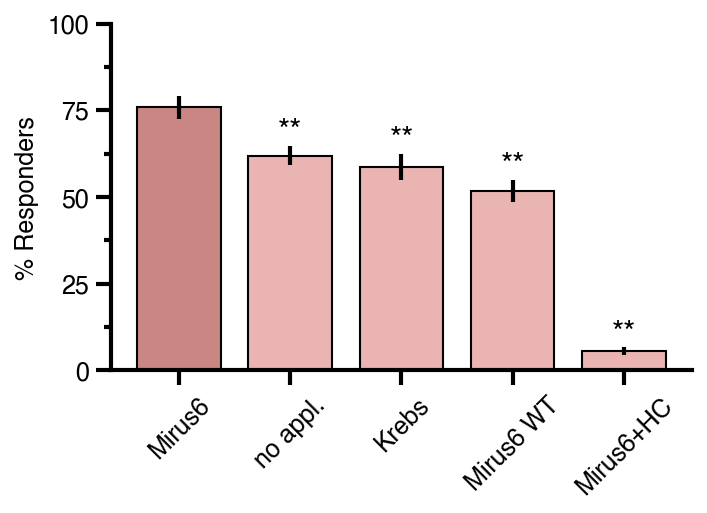

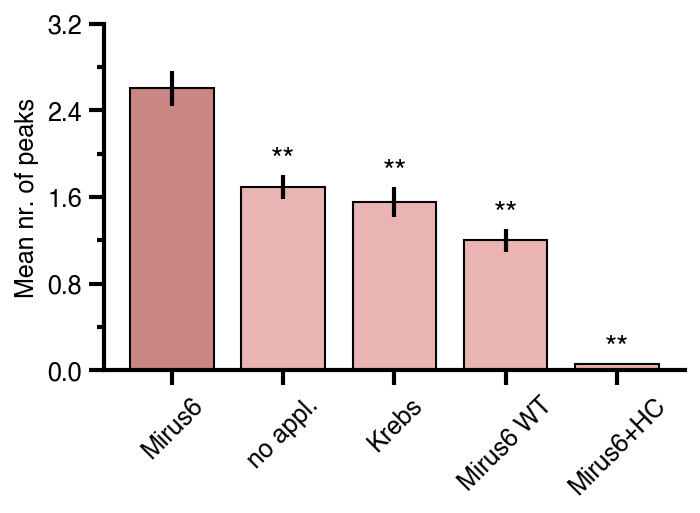

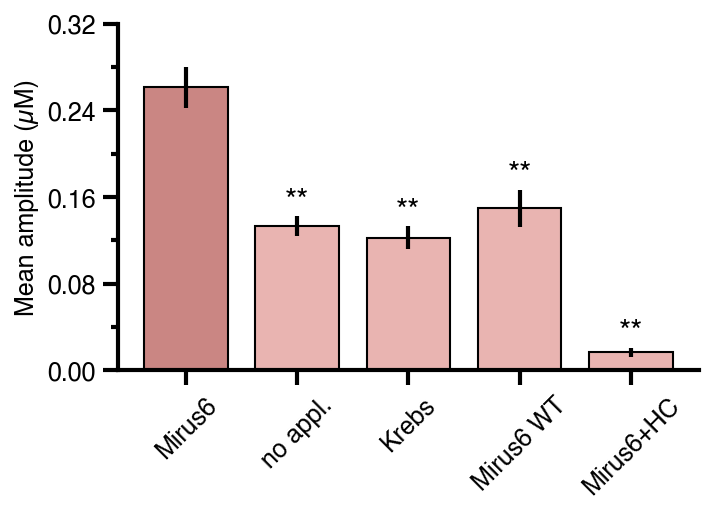

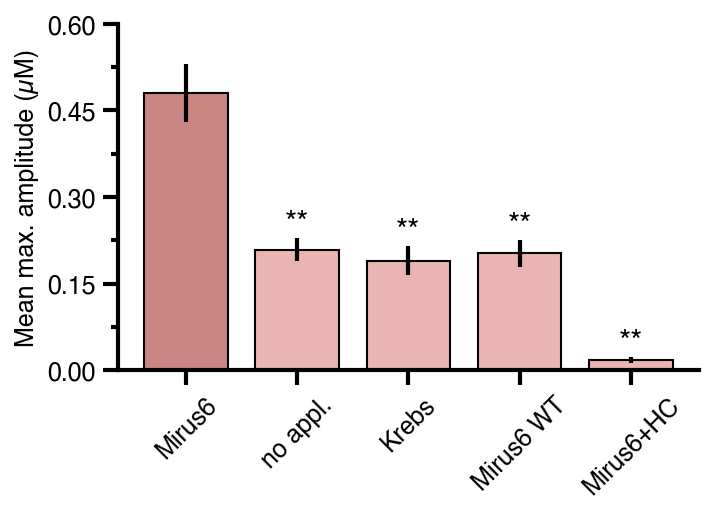

In [37]:
agg_outputs: List[pd.DataFrame] = []
for condition in [
    #CHOs
    "Mirus6",
    "nothing",
    "Krebs",
    "Mirus6wt",
    "Mirus6+HC",
    # liposomes
    # "ves2",
    # "control",
    # "ves2+HC",
    # "ves2wt",
    # EVs
    # "EVs",
    # "medium",
    # "EVs+HC",
]:
    agg_output = pd.read_excel(f"./{OUTPUT_PATH}/cell_analysis_{condition}.xlsx")
    # scale down the y values by a factor of 1000
    for c in agg_output.columns:
        if "amplitude" in c:
            agg_output[c] = agg_output[c] / 1000.0
    agg_outputs.append(agg_output)

comparisons = {
    "peak_count": ["response_rate", "mean"],
    "mean_peak_amplitude": ["mean"],
    "max_peak_amplitude": ["mean" ] 
}
plot_agg_output_comparison(
    agg_outputs=agg_outputs,
    comparisons=comparisons,
    n_major_ticks=4,
    n_minor_to_major=2,
    figsize=(5, 3),
    colors=("#D67B77", "#F2ABA8"),
    alpha=1.0,
    x_rotation=45,
    width=0.75,
    condition_alias_dict={
        "nothing": "no appl.",
        "Mirus6wt": "Mirus6 WT",
        # "Unknown": "ves2+HC",
        "ves2": "lipo",
        "control": "vehicle",
        "Unknown": "lipo+HC",
        # "Unknown": "EVs+HC",
        "ves2+HC": "lipo+HC",
        "ves2wt": "lipo WT"
    },
    colname_alias_dict={
        "mean_peak_amplitude": "amplitude (µM)",
        "max_peak_amplitude": "max. amplitude (µM)",
        "peak_count": "nr. of peaks"
    },
    errorbar_type="se",
    savepath=f"./{OUTPUT_PATH}"
)

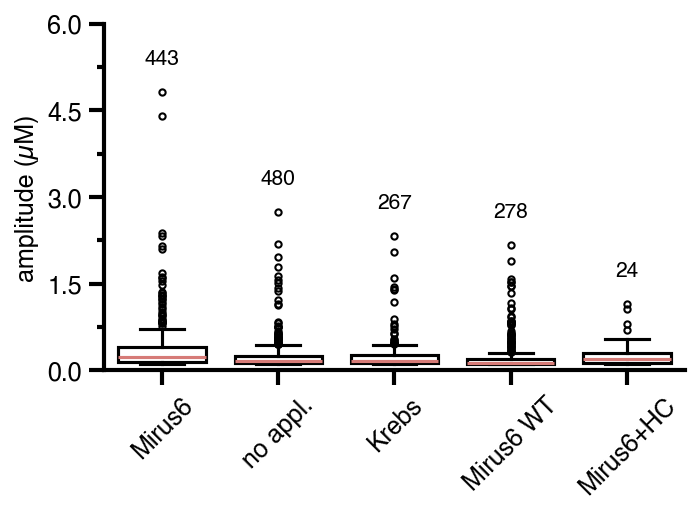

In [71]:
agg_outputs: List[pd.DataFrame] = []
for condition in [
    #CHOs
    "Mirus6",
    "nothing",
    "Krebs",
    "Mirus6wt",
    "Mirus6+HC",
    # liposomes
    # "ves2",
    # "control",
    # "ves2+HC",
    # "ves2wt",
    # EVs
    # "EVs",
    # "medium",
    # "EVs+HC",
]:
    agg_output = pd.read_excel(f"./{OUTPUT_PATH}/peak_analysis_{condition}.xlsx")
    # scale down the y values by a factor of 1000
    for c in agg_output.columns:
        if "amplitude" in c:
            agg_output[c] = agg_output[c] / 1000.0
    agg_outputs.append(agg_output)

plot_output_distribution(
    agg_outputs=agg_outputs,
    id_colname="peak_ID",
    columns_to_plot=["amplitude"],
    n_major_ticks=4,
    n_minor_to_major=2,
    figsize=(5, 3),
    x_rotation=45,
    condition_alias_dict={
        "nothing": "no appl.",
        "Mirus6wt": "Mirus6 WT",
        "ves2": "lipo",
        "control": "vehicle",
        "ves2+HC": "lipo+HC",
        "ves2wt": "lipo WT"
    },
    colname_alias_dict={
        "amplitude": "amplitude (µM)",
    },
)


In [57]:
# from typing import Callable
# def test(agg_output: pd.DataFrame, func: Callable):
#     if func is np.mean:
#         _mean = agg_output[colname].mean()
#         _se = agg_output[colname].std() / (len(agg_output) - 1) ** 0.5
#         _ci95 = stats.t.ppf(0.975, (len(agg_output) - 1), loc = 0, scale = _se)
#         _dict_plot = {"condition": [], f"mean_{colname}": [], f"stderr_{colname}": [], f"ci95_{colname}": []}
#         _dict_plot["condition"].append(condition_0)
#         _dict_plot[f"mean_{colname}"].append(_mean)
#         _dict_plot[f"stderr_{colname}"].append(_se)
#         _dict_plot[f"ci95_{colname}"].append(_ci95)
    

In [ ]:
agg_output0 = pd.read_excel("./output/cell_analysis_Krebs.xlsx")
agg_output1 = pd.read_excel("./work/output/cell_analysis_Mirus6.xlsx")

# Test

In [29]:
trace_arr = df_data[2].values
_above_threshold: NDArray = trace_arr > 100
# a segment boundary is where 0 -> 1 or 1 -> 0 transition happens
segment_boundaries: NDArray = np.where(np.diff(_above_threshold.astype("int")) != 0)[0] + 1
# split the values into consecutive segments, for now this includes the below threshold parts too
segments: List[NDArray] = np.split(trace_arr, segment_boundaries)
# keep track of absolute position of each value on the segments
segment_abs_idx: List[NDArray] = np.split(np.arange(0, len(trace_arr)), segment_boundaries)
# find the postion of the max in each segment
segments_max_idx: List[int] = [x.argmax() for x in segments]
# convert to absolute position (and array format)
segment_max_abs_idx: NDArray = np.array([x[i] for x, i in zip(segment_abs_idx, segments_max_idx)])
# get the max values
segments_max_vals: NDArray = np.take(trace_arr, segment_max_abs_idx)
_above_threshold: NDArray = segments_max_vals > 100
print(segments_max_vals[_above_threshold])
print(segment_max_abs_idx[_above_threshold])
print(trace_arr[segment_max_abs_idx[_above_threshold]])


[181.13745077 100.99038484 100.31945445 100.52068837 100.55230955
 229.40869911]
[  3  71  91 103 129 658]
[181.13745077 100.99038484 100.31945445 100.52068837 100.55230955
 229.40869911]



In [11]:
np.diff((df_data[2].values > 100).astype("int"))

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [12]:
# def _smooth_ma(series: pd.Series, window: int):
#     return series.rolling(window=window).mean()

# def _apply_savgol(series, window_length: int, polyorder: int, deriv: int=0):
#     return signal.savgol_filter(x=series, window_length=window_length, polyorder=polyorder, deriv=deriv)

# def _find_peak_idx_test(
#     series: pd.Series,
#     prominence_in_sd: float = 2,
#     wlen: int = 5
# ) -> NDArray:
#     q25, q75 = np.quantile(series, [0.25, 0.75])
#     sd = (q75 - q25) / 1.349
#     return signal.find_peaks(series.to_numpy(), prominence=prominence_in_sd * sd, wlen=wlen)[0]

# def test_plot(
#     df_trace: pd.DataFrame,
#     df_smoothed_trace: pd.DataFrame,
#     peak_idx: NDArray
# ):
#     time_colname = "time(m)"
#     cell_nr = [x for x in df_trace.columns if x!=time_colname][0]
#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(df_trace[time_colname], df_trace[cell_nr], color="black", alpha=0.8)
#     ax.plot(df_smoothed_trace[time_colname], df_smoothed_trace[cell_nr], color="blue", alpha=0.5)
#     ax.vlines(
#         x=df_trace[time_colname].iloc[peak_idx],
#         ymin=np.zeros(shape=len(peak_idx)),
#         ymax = df_trace[cell_nr].iloc[peak_idx],
#         colors="red",
#         linewidths=1
#     )
#     fig.show()


In [13]:
# TRACE_COL = 4
# MA_WINDOW = 51
# series = df_proc[TRACE_COL].copy()
# # series = _smooth_ma(series, window=51)
# vec_d0 = _apply_savgol(series=series, window_length=MA_WINDOW, polyorder=3, deriv=0)
# # plt.plot(series.to_numpy())
# vec_d1 = _apply_savgol(series=series, window_length=MA_WINDOW, polyorder=3, deriv=1)
# # plt.plot(vec_d1)
# vec_d2 = _apply_savgol(series=series, window_length=MA_WINDOW, polyorder=3, deriv=2)
# # plt.plot(vec_d2)
# # find where first derivative crosses zero and second derivative is positive
# peak_idx = np.intersect1d(
#     np.where(np.diff(np.sign(vec_d1)))[0],
#     np.where(vec_d2<0)[0],
#     assume_unique=True,
#     return_indices=False
# )
# # peak_idx = peak_idx


# # peak_idx = _find_peak_idx_test(
# #     series=series,
# #     prominence_in_sd=2.5,
# #     wlen=int(len(df_data)/7.5)
# # )
# _df_trace =  df_proc[["time(m)", TRACE_COL]]
# _df_smoothed = _df_trace.copy()
# _df_smoothed[TRACE_COL] = vec_d0
# test_plot(
#     _df_trace,
#     _df_smoothed,
#     peak_idx
# )

In [88]:
nothing_example = f'{DATA_PATH}/nothing/23112023_05.xlsx'
mirus2_example = f'{DATA_PATH}/Mirus2/20231129_05.xlsx'
mirus6_example = f'{DATA_PATH}/Mirus6/20231002_03.xlsx'
mirus60_example = f'{DATA_PATH}/Mirus60/16102023_03.xlsx'
mirus6_wt_example = f'{DATA_PATH}/Mirus6_wt/06122023_02.xlsx'
mirus6HC_example = f'{DATA_PATH}/Mirus6+HC/23112023_06.xlsx'
zero_ca2_example = f'{DATA_PATH}/0_Ca2+/29112023_02.xlsx'
long_example = f'{DATA_PATH}/long_measurements/20231206_05.xlsx'
krebs_example = f'{DATA_PATH}/Krebs/Krebs.xlsx'
ves2hc_example = f'{DATA_PATH}/ves2+HC/20230503_11.xlsx'
e9_example = f'{DATA_PATH}/e9/20230505_06.xlsx'
ev_example = f'{DATA_PATH}/EVs/20230901_02.xlsx'
evhc_example = f'{DATA_PATH}/EVs+HC/20230905_04.xlsx'
control_example = f'{DATA_PATH}/control/20230503_13.xlsx'

df_data = (
    pd.read_excel(control_example, sheet_name=0)
    .rename({'Unnamed: 0': 'time(m)'}, axis=1)
    # .interpolate(method='linear', limit_area="inside")
    .dropna(axis=0)
)
_df_data_start = df_data[
    (df_data['time(m)'] >= 1.5) & (df_data['time(m)'] <= 2)
].drop('time(m)', axis=1)
stdev_base: pd.Series = _df_data_start.std(axis=0)
df_data = df_data[
    # (df_data['time(m)'] >= 5.0) & (df_data['time(m)'] <= 22.76)
    df_data['time(m)'] <= 22.76
    # df_data['time(m)'] <= 57.51
]

In [52]:
# earliest_peak_idx: int = len(df_data[df_data['time(m)'] < 5.0])
# df_proc, df_peaks = process_data(
#     df_input=df_data,
#     time_colname='time(m)',
#     baseline_poly_order=2,
#     prominence_in_sd=1.5,
#     wlen=int(len(df_data)/7.5),
#     min_peak_amplitude=50,
#     earliest_peak_idx=earliest_peak_idx,
#     s_stdev=stdev_base
# )
# 0830

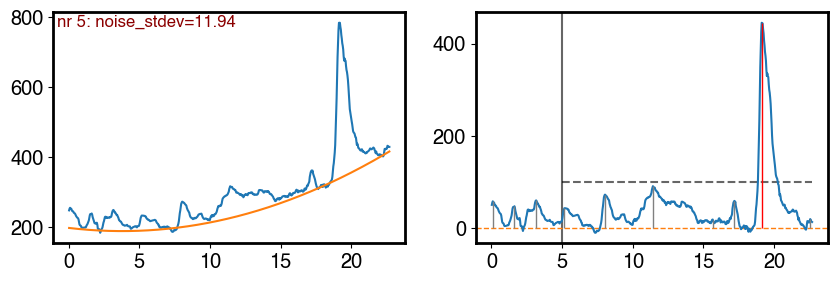

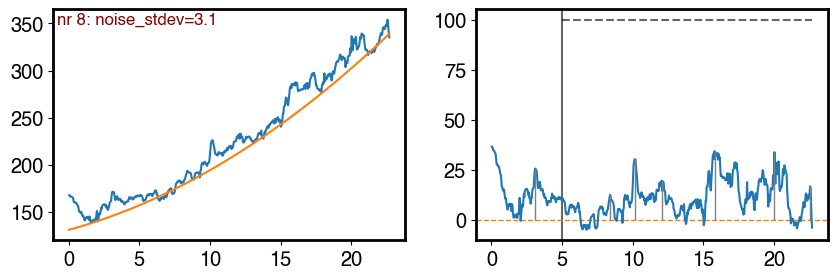

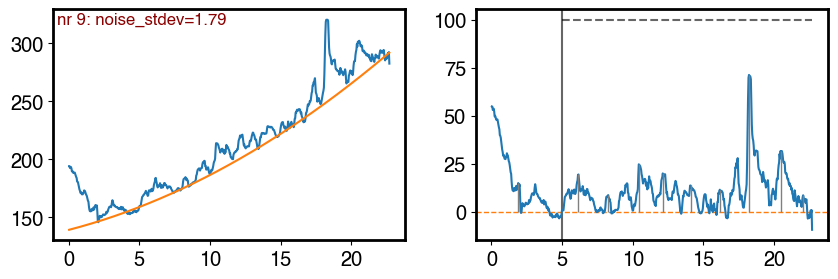

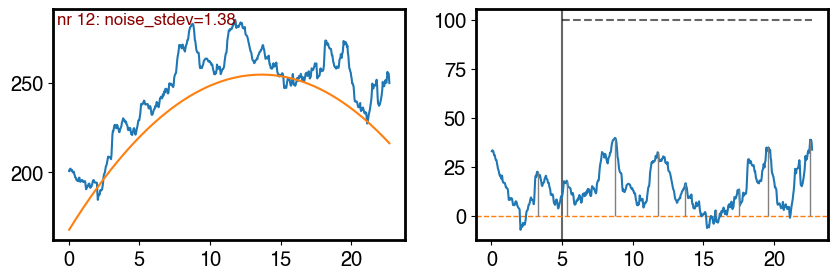

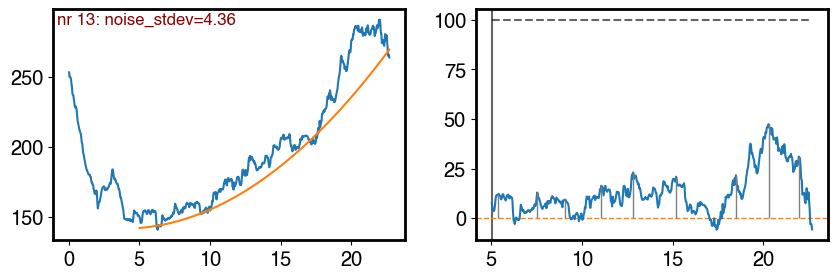

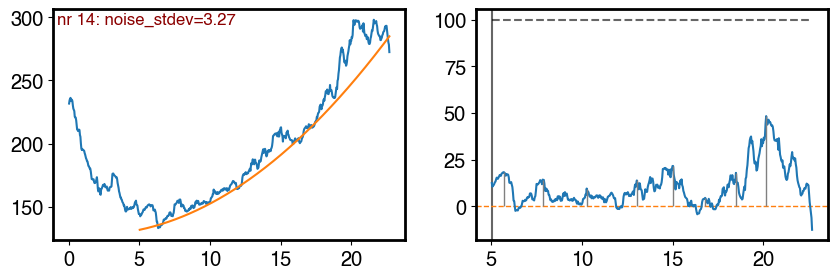

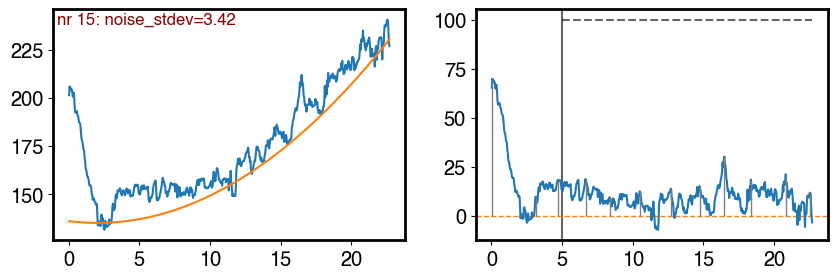

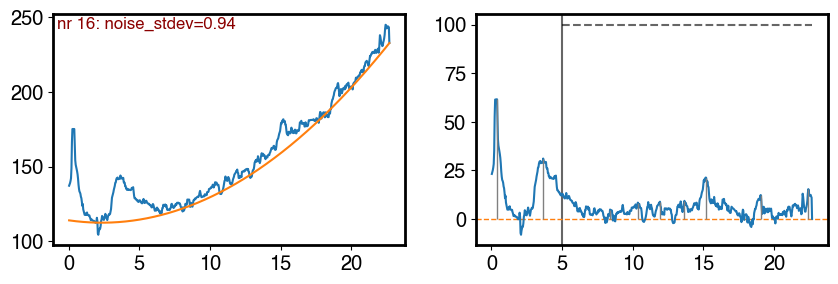

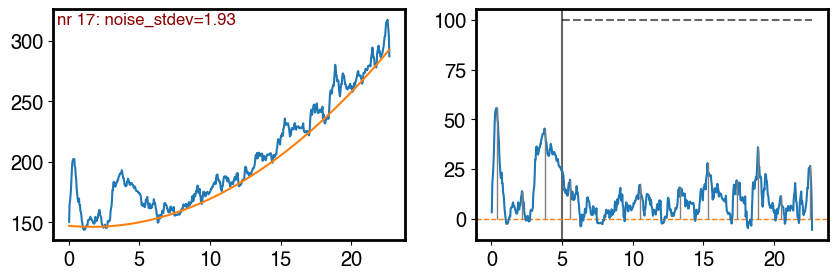

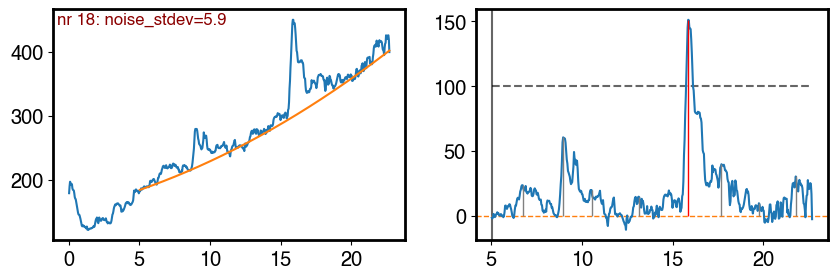

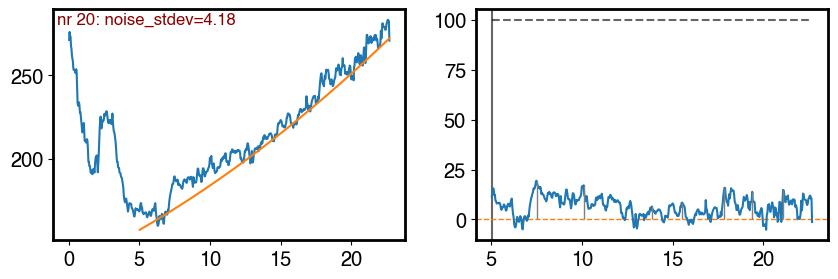

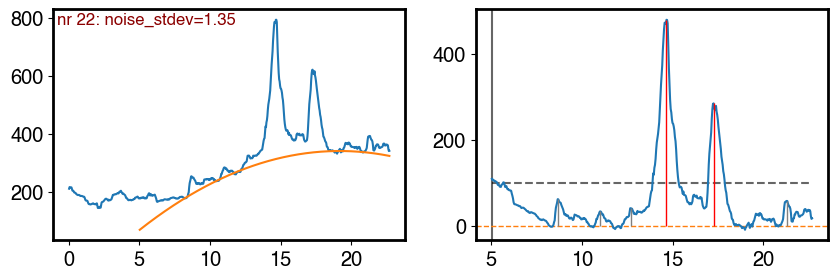

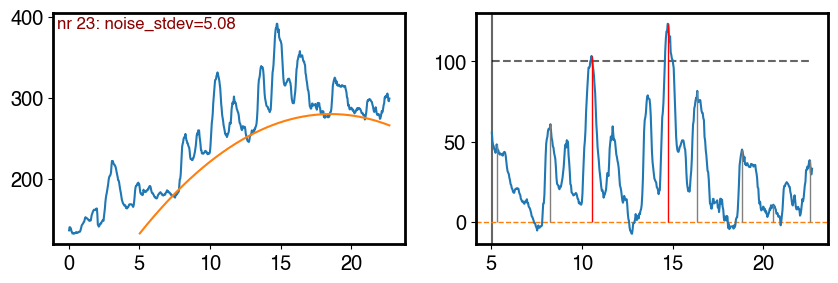

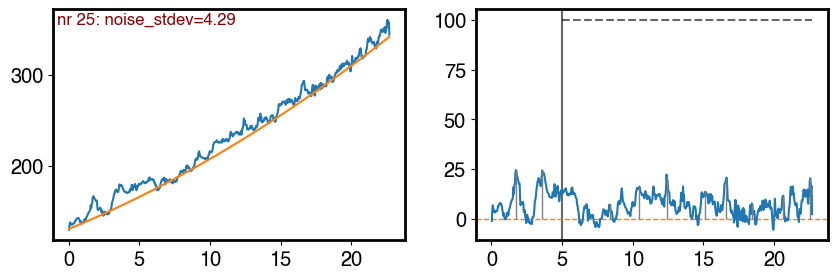

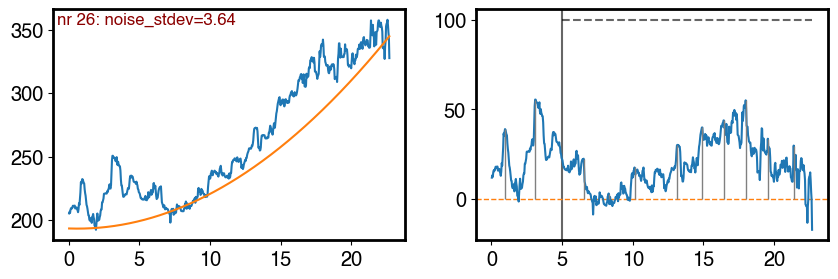

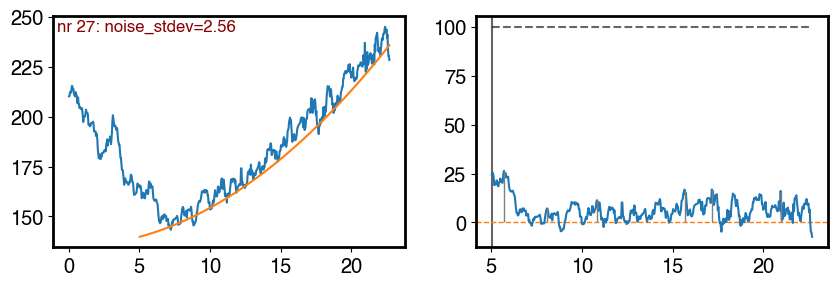

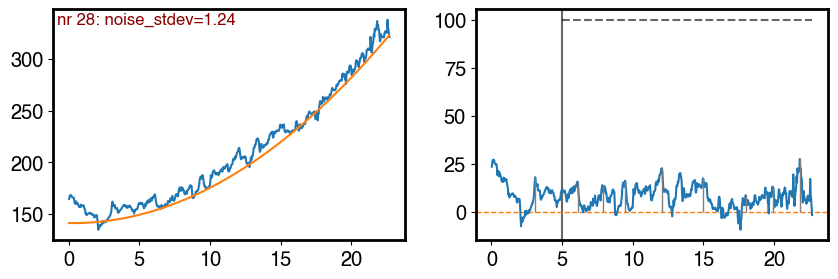

In [89]:
earliest_peak_idx: int = len(df_data[df_data['time(m)'] < 5.0])
baseline_fitter = ModPolyCustomBaseLineFitter(
    poly_order=2,
    optional_segment_length=earliest_peak_idx
)
peak_detector = RobustNoiseSDScipyPeakDetector(
    prominence_in_stdev=5,
    wlen=50,
    distance=45,
    min_peak_amplitude=(100.0, 100.0),
    earliest_peak_idx=earliest_peak_idx,
)

plot_processing(
    df_input=df_data,
    time_colname='time(m)',
    baseline_fitter=baseline_fitter,
    peak_detector=peak_detector,
    s_stdev=stdev_base
)